# Importing necessary Libraries

In [3]:
import pandas as pd
import re
import datetime
import emoji
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import sys
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [4]:
%matplotlib notebook
%matplotlib inline

# Some Helper Functions

In [5]:
# Extracts the dates from a message
def get_dates(message):
    match = re.search('^([0-9]+)(\/)([0-9]+)(\/)([0-9][0-9])', message)
    if match is not None:
        date = datetime.datetime.strptime(match.group(), '%d/%m/%y').date()
        return date
    else:
        return None

In [6]:
# Extracts time of sending of message
def get_time(message):
    match = re.search('[0-9][0-9]:[0-9][0-9]', message)
    if match is not None:
        time_object = datetime.datetime.strptime(match.group(), '%H:%M').time()
        return time_object
    else:
        return None

In [7]:
# Extracts sender of message
def get_author(message):
    match = re.search("- ([^:]*):", message)
    if match is not None:
        string = match.group(1)
        return string
    else:
        return None

In [8]:
# Extracts message content
def get_text(message):
    match = re.search(": (.*)", message)
    if match is not None:
        string = match.group(1)
        return string
    else:
        return None

In [9]:
# Extracts emojis from message
def extract_emojis(message):
    data = re.findall(r'[^\w\s,]', message)
    emoji_list = []
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)
    return emoji_list

In [10]:
# Cleans the file to ensure correct fields are added to the dataframe
# Problems in file: lines may not start with a date (which is the expected behaviour)
# In such a case, the newline character at the end of the previous line is deleted.
# This is done because if a sender inserts a new line character (presses the enter key) within a message it starts
#        a new line within the file too indicating that it might be a new message, which is not true.
def clean_file(file):
    a_file = open(file, encoding="utf-8")
    i = 0
    prob_lines = []
    for line in a_file:
        match = re.search('^([0-9]+)(\/)([0-9]+)(\/)([0-9][0-9])', line)
        if match is None:
            prob_lines.append(i)
        i += 1
    prev_lines = [index - 1 for index in prob_lines]
    a_file = open(file, "r")
    string_without_line_breaks = ""
    i = 0
    for line in a_file:
        if i in prev_lines:
            string_without_line_breaks += line.rstrip() + " "
            i += 1
        else:
            string_without_line_breaks += line
            i += 1
    a_file.close()
    a_file = open(file, 'w')
    n = a_file.write(string_without_line_breaks)
    a_file.close()

In [11]:
# Extracts the valuable information from the text file and creates a dataframe from the information
def create_df(file):
    clean_file(file)
    df = pd.DataFrame(columns=['Date', 'Time', 'Sender', 'Message', 'Emojis', 'Num_Words', 'Text_Length', 'Num_Emojis'])
    i = 0
    with open(file, encoding="utf-8") as fp:
        for line in fp:
            text = get_text(line)
            if text is None:
                text = ""
            new_row = {'Date': get_dates(line), 'Time': get_time(line), 'Sender': get_author(line), 'Message': text, 
                       'Emojis': extract_emojis(text), 'Num_Words': len(text.split()), 'Text_Length': int(len(text)), 
                       'Num_Emojis': len(extract_emojis(text))}
            df = df.append(new_row, ignore_index=True)
#     df.drop(index = [0, 1, 2], inplace=True)
#     df.reset_index(inplace=True, drop=True)
    return df[df['Message'] != '']


### Functions to Handle Emojis

In [12]:
def count_occurences(item, df):
    count = 0
    for row in df['Emojis']:
        if item in row:
            count += row.count(item)
    return count

In [13]:
def top_emojis(df):
    total_emojis_list = list(set([a for b in df.Emojis for a in b]))
    num_occur = []
    for emoji in total_emojis_list:
        num_occur.append(count_occurences(emoji, df))
    emoji_df = pd.DataFrame(list(zip(total_emojis_list, num_occur)), columns = ['Emojis', 'Num_Occurences'])
    emoji_df.sort_values(by='Num_Occurences', ascending=False, inplace=True, ignore_index=True)
    top5_emojis = emoji_df['Emojis'][0:5]
    return top5_emojis

In [14]:
# Plots the distribution of messages sent during different hours of the day
def time_distribution(df):
    time_df = df.sort_values(by='Time', ascending=True, ignore_index=True)
    time_df.set_index('Time', inplace=True)
    i = pd.date_range('2018-04-09', periods=1440, freq='1min')
    new = pd.DataFrame(i, columns=['Time'])
    new['Time'] = pd.to_datetime(new['Time']).dt.time
    new.set_index('Time', inplace=True)
    result = new.join(time_df)
    time_wise = result.groupby(['Time']).count().reset_index()
    time_wise = time_wise[['Time', 'Message']]
    plt.figure(figsize=(9,6))
    plt.plot(time_wise['Message'])
    a = np.array([i*60 for i in range(0, 25)])
    plt.xticks(a, np.arange(0, 25))
    plt.ylabel('Num Messages Sent')
    plt.xlabel('Hour (Gulf Standard Time)')
    plt.title('Messages sent during different hours of the day')

In [15]:
# Extracts the number of messages sent during different days of the week and plots the information
def day_distribution(df):
    day_df = df.sort_values(by='Date', ascending=True, ignore_index=True)
    days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_df['Day'] = day_df['Date'].apply(lambda x: x.weekday())
    result = day_df.groupby(['Day']).count().reset_index()
    result = result[['Day', 'Message']]
    plt.figure()
    plt.plot(result['Message'])
    plt.xticks(np.arange(0, 7), days_of_week, rotation=30)   
    plt.ylabel('Num Messages Sent')
    plt.xlabel('Day of the Week')
    plt.title('Messages sent on different days of the week')

In [16]:
# Prints some useful insights for each user
def print_sender_info(df):
    for name in df.Sender.unique():
        name_df = df[df['Sender'] == name]
        print(f"{name}: ")
        num_msgs = len(name_df)
        print(f"\tMessages to the group: {num_msgs}")
        num_media = len(name_df[name_df['Message'] == "<Media omitted>"])
        print(f"\tMedia files to the group: {num_media}")
        num_emojis = name_df['Num_Emojis'].sum()
        print(f"\tEmojis to the group: {num_emojis}")
        words_per_message = name_df['Num_Words'].sum() / num_msgs
        print(f"\tWords per message: {words_per_message}")
        print(f"\tTop 5 Emojis:")
        emoji_list = top_emojis(name_df)
        for emoji in emoji_list:
            print(f"\t\t{emoji}")
#         time_distribution(name_df)
#         day_distribution(name_df)
        

In [17]:
# Prints the cumulative information of the group chat
def print_group_info(df):
    num_msgs = len(df)
    print(f"Messages to the group: {num_msgs}")
    num_media = len(df[df['Message'] == "<Media omitted>"])
    print(f"Media files to the group: {num_media}")
    num_emojis = df['Num_Emojis'].sum()
    print(f"Emojis to the group: {num_emojis}")
    words_per_message = df['Num_Words'].sum() / num_msgs
    print(f"Words per message: {words_per_message}")
    emoji_list = top_emojis(df)
    print("Top 5 Emojis:")
    for emoji in emoji_list:
        print(f"\t{emoji}")
    time_distribution(df)
    day_distribution(df)

In [24]:
# Creates a word cloud using the text sent on the group. The larger words are the most frequently used words
def make_word_cloud(df):
    text = " ".join(review for review in df.Message)
    stopwords = set(STOPWORDS)
    stopwords.update(["Media", "omitted"])
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [33]:
group1 = create_df('Group 1.txt')


In [41]:
group1

,Date,Time,Sender,Message,Emojis,Num_Words,Text_Length,Num_Emojis
5,2020-06-16,19:34:00,Sender1,Guys did u understand anything abt the projects,[],8,47,0
6,2020-06-16,19:35:00,Sender1,Im confused af,[],3,14,0
7,2020-06-16,19:37:00,Sender1,"""Pls give it product preference by typing"" Wha...",[],13,70,0
8,2020-07-22,15:48:00,Sender2,Guys. What EXACTLY do we have to do for the ec...,"[😂, 😂, 😂, 🔫]",15,77,4
9,2020-08-10,18:25:00,Sender3,Should we also do the global warming project,[],8,44,0
...,...,...,...,...,...,...,...,...
21916,2020-05-27,22:25:00,Sender2,You deleted this message,[],4,24,0
21917,2020-05-27,22:25:00,Sender2,Oh wait blah,[],3,12,0
21918,2020-05-27,22:25:00,Sender2,nvm,[],1,3,0
21919,2020-05-31,21:26:00,Sender4,I'm on Instagram as @speakingpapers. Install t...,[],15,163,0


In [34]:
# Merging different numbers of the same people under 1 sender
name1 = group1.Sender.unique()[0]
name2 = group1.Sender.unique()[1]
name3 = group1.Sender.unique()[2]
name4 = group1.Sender.unique()[3]
name5 = group1.Sender.unique()[4]
name6 = group1.Sender.unique()[5]
name7 = group1.Sender.unique()[6]
group1.loc[group1['Sender'] == name1, 'Sender'] = 'Sender1'
group1.loc[group1['Sender'] == name2, 'Sender'] = 'Sender2'
group1.loc[group1['Sender'] == name3, 'Sender'] = 'Sender3'
group1.loc[group1['Sender'] == name4, 'Sender'] = 'Sender4'
group1.loc[group1['Sender'] == name5, 'Sender'] = 'Sender3'
group1.loc[group1['Sender'] == name6, 'Sender'] = 'Sender4'
group1.loc[group1['Sender'] == name7, 'Sender'] = 'Sender4'

Messages to the group: 21896
Media files to the group: 1669
Emojis to the group: 7195
Words per message: 5.392035074899525
Top 5 Emojis:
	😂
	😭
	🏻
	♀
	❤


Sender1: 
	Messages to the group: 5821
	Media files to the group: 302
	Emojis to the group: 1605
	Words per message: 4.666552138807765
	Top 5 Emojis:
		😂
		❤
		😭
		♀
		🙃
Sender2: 
	Messages to the group: 6067
	Media files to the group: 606
	Emojis to the group: 4111
	Words per message: 6.016977089170925
	Top 5 Emojis:
		😂
		😭
		🏻
		♀
		❤
Sender3: 
	Messages to the group: 8008
	Media files to the group: 614
	Emojis to the group: 944
	Words per message: 5.640609390609391
	Top 5 Emojis:
		😂
		😭
		🙄
		😏
		😇
Sender4: 
	Messages to the group: 2000
	Media files to the group: 147
	Emojis to the group: 535
	Words per message: 4.6125
	Top 5 Emojis:
		😂
		😭
		🤦
		♀
		😒


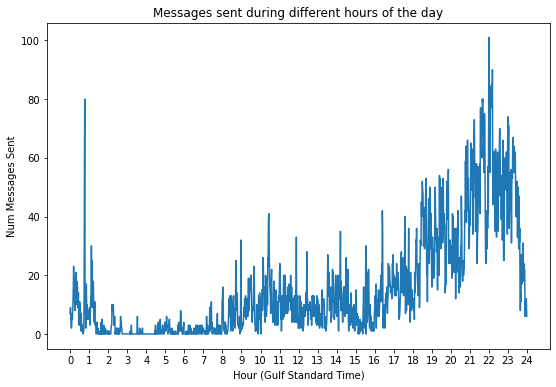

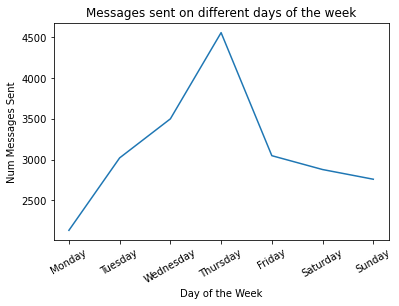

In [36]:
print_group_info(group1)
print('\n')
print_sender_info(group1)

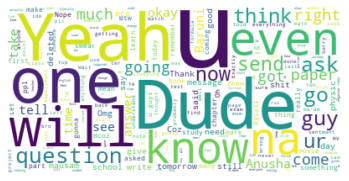

In [37]:
make_word_cloud(group1)

# Insights Developed from Another Chat

Messages to the group: 38894
Media files to the group: 1361
Emojis to the group: 25932
Words per message: 4.6611816732658
Top 5 Emojis:
	😂
	😭
	❤
	🏻
	♀


Anusha: 
	Messages to the group: 17812
	Media files to the group: 572
	Emojis to the group: 15465
	Words per message: 5.123568380866831
	Top 5 Emojis:
		😂
		😭
		❤
		🏻
		♀
Khushbu: 
	Messages to the group: 21082
	Media files to the group: 789
	Emojis to the group: 10467
	Words per message: 4.270515131391709
	Top 5 Emojis:
		😂
		😭
		❤
		🙃
		😐


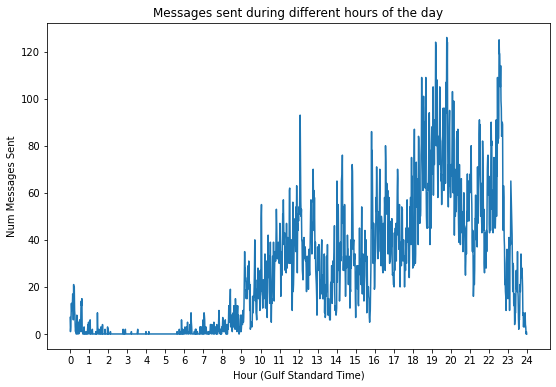

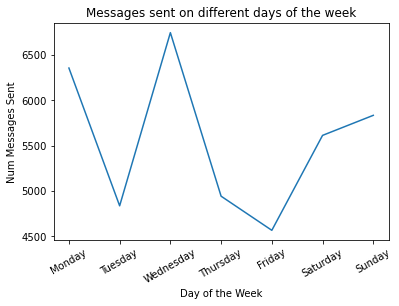

In [746]:
print_group_info(khush_df)
print('\n')
print_sender_info(khush_df)

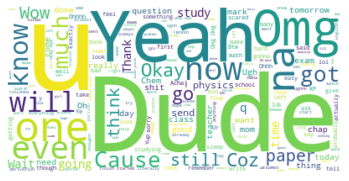

In [749]:
make_word_cloud(khush_df)